<a href="https://colab.research.google.com/github/bodamohannaik/DLAI-TF-DPC/blob/master/C4/W2/time_series_c4_w2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
  """
  plot Data
  @param time: x axis data
  @param series: y axis data, iterable or tuple of iterables
  @param format: format connecting points
  @param start: start index
  @param end: end index
  """
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
  if type(series) is tuple:
    for sub_series in series:
      axs.plot(time[start:end], sub_series[start:end], linestyle=format)
  else:
    axs.plot(time[start:end], series[start:end], linestyle=format)
  axs.set_xlabel("Time")
  axs.set_ylabel("Value")
  axs.grid(True)
  fig.show()

In [3]:
def trend(time, slope=0):
  """
  straight line data
  @param time: x axis data
  @param slope: line slope
  @return : y = slope*time
  """
  return  slope*time

In [4]:
def seasonal_pattern(season_time):
  """
  seasonal pattern data
  @param season_time: Periodic time - x axis
  @return: random seasonal pattern data
  """
  return np.where(season_time<0.4, np.cos(2*np.pi*season_time), 1/(np.exp(3*season_time)))



In [5]:
def seasonality(time, period, amplitude=1, phase=0):
  """
  seasonal pattern repeating with period
  @param time: Time
  @param period: Time period of the pattern
  @param amplitude: Amplitude of the pattern
  @param phase: phase shift applied to the pattern time
  @return: Seasonal pattern data
  """

  season_time = ((time+phase)%period)/period
  return amplitude*seasonal_pattern(season_time=season_time)

In [6]:
def noise(time, noise_level=1, seed=None):
  """
  Random noise
  @param time: time steps
  @noise_level: noise amplitude
  """
  rnd = np.random.RandomState(seed=seed)
  return noise_level*rnd.randn(len(time))

# Data

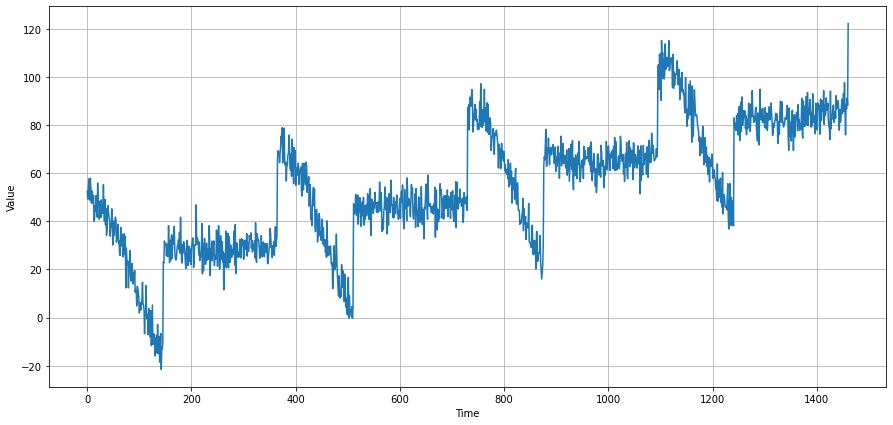

In [7]:
time = np.arange(4*365+1)
# parameters
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
# data
series = baseline+seasonality(time=time, period=365, amplitude=amplitude, phase=0)+trend(time=time, slope=slope)+noise(time=time, noise_level=noise_level, seed=42)
# plot
plot_series(time = time, series=series)


In [8]:
# split data into train and validation
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
print(f"Time train shape: {time_train.shape}, X train shape: {x_train.shape}")
print(f"Time validation shape: {time_valid.shape}, X validation shape: {x_valid.shape}")

Time train shape: (1100,), X train shape: (1100,)
Time validation shape: (361,), X validation shape: (361,)


# Time series Data Preparation

In [9]:
window_size = 20
batch_size = 32 
shuffle_buffer = 1000

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """
  prepare window sized time series data 
  @param series: data
  @param window_size: size of the window
  @param batch_size: batch size of the dataset
  @param shuffle_buffer: shuffle buffer size
  @return: Batched and shuffled dataset with window size as input features and next element as feature
  """

  print(f"series shape: {series.shape}")
  dataset = tf.data.Dataset.from_tensor_slices(series)
  print(f"dataset : {dataset}")
  window_dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
  print(f"window dataset: {window_dataset}")
  flat_window_dataset = window_dataset.flat_map(lambda x: x.batch(window_size+1))
  print(f"flat window dataset: {flat_window_dataset}")
  split_window_dataset = flat_window_dataset.map(lambda x: (x[:-1], x[-1]))
  print(f"split window dataset: {split_window_dataset}")
  split_window_dataset= split_window_dataset.shuffle(shuffle_buffer)
  print(f"split window dataset shuffled: {split_window_dataset}")
  split_window_dataset = split_window_dataset.batch(batch_size).prefetch(1)
  print(f"split window dataset: {split_window_dataset}")
  return split_window_dataset

In [11]:
dataset = windowed_dataset(series=x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer)

series shape: (1100,)
dataset : <TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float64, name=None)>
window dataset: <WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorShape([]))>
flat window dataset: <FlatMapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.float64, name=None)>
split window dataset: <MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>
split window dataset shuffled: <ShuffleDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>
split window dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


# Model

In [12]:
model = tf.keras.Sequential(layers=[
                                    tf.keras.layers.Input(shape=(window_size,)),
                                    tf.keras.layers.Dense(units=32, activation='relu'),
                                    tf.keras.layers.Dense(units=16, activation='relu'),
                                    tf.keras.layers.Dense(units=1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                672       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mse", metrics="mae")

In [14]:
model.fit(dataset, epochs=100)

Epoch 1/100
34/34 [==============================] - 1s 16ms/step - loss: 169.6684 - mae: 9.1695
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 52.4080 - mae: 5.3917
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 48.7504 - mae: 5.2154
Epoch 4/100
34/34 [==============================] - 0s 2ms/step - loss: 45.2735 - mae: 4.9939
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 50.7925 - mae: 5.3878
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 45.9366 - mae: 5.0528
Epoch 7/100
34/34 [==============================] - 0s 2ms/step - loss: 44.5572 - mae: 5.0314
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 41.1757 - mae: 4.6852
Epoch 9/100
34/34 [==============================] - 0s 4ms/step - loss: 43.9919 - mae: 4.9996
Epoch 10/100
34/34 [==============================] - 0s 3ms/step - loss: 45.1167 - mae: 4.9961
Epoch 11/100
34/34 [===========================

In [15]:
val_dataset = windowed_dataset(series=series[split_time-window_size:], window_size=window_size, batch_size=batch_size, shuffle_buffer=1)

series shape: (381,)
dataset : <TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float64, name=None)>
window dataset: <WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorShape([]))>
flat window dataset: <FlatMapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.float64, name=None)>
split window dataset: <MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>
split window dataset shuffled: <ShuffleDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>
split window dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [16]:
x_val_predicted= model.predict(val_dataset)

In [17]:
x_val_predicted.shape

(361, 1)

In [18]:
x_val_predicted = x_val_predicted.squeeze()

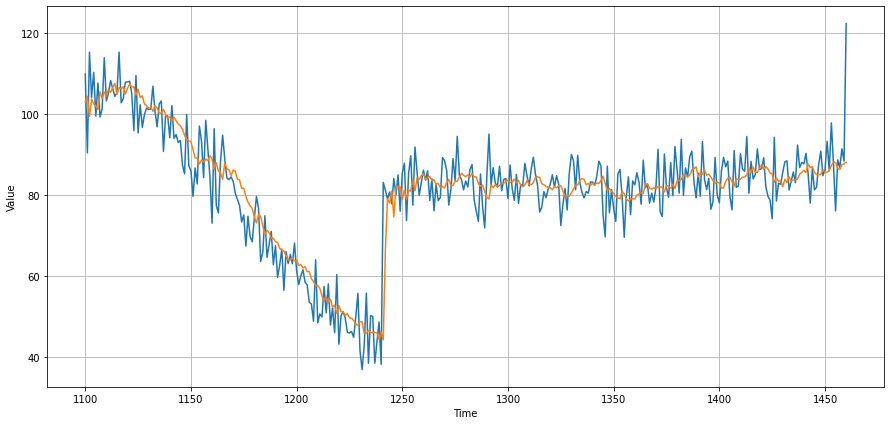

In [19]:
plot_series(time_valid, (x_valid, x_val_predicted))

In [20]:
mse = tf.keras.metrics.mean_squared_error(x_valid, x_val_predicted)
mae = tf.keras.metrics.mean_absolute_error(x_valid, x_val_predicted)
print(f"validation mse :{mse}, mae:{mae}")

validation mse :39.02073669433594, mae:4.677069664001465


# Learning Rate Tuning

In [43]:
model = tf.keras.Sequential(layers=[
                                    tf.keras.layers.Input(shape=(window_size,)),
                                    tf.keras.layers.Dense(units=32, activation='relu'),
                                    tf.keras.layers.Dense(units=16, activation='relu'),
                                    tf.keras.layers.Dense(units=1)
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                672       
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [44]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (10e-6)*(10**(epoch/20)))

In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse", metrics="mae")
model.fit(dataset, epochs=100, callbacks=[lr_callback])

Epoch 1/100
34/34 [==============================] - 1s 2ms/step - loss: 1171.1162 - mae: 30.3287 - lr: 1.0000e-05
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 1104.3596 - mae: 29.3987 - lr: 1.1220e-05
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 1032.3715 - mae: 28.3590 - lr: 1.2589e-05
Epoch 4/100
34/34 [==============================] - 0s 2ms/step - loss: 954.9901 - mae: 27.1829 - lr: 1.4125e-05
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 872.0924 - mae: 25.8933 - lr: 1.5849e-05
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 785.6334 - mae: 24.4426 - lr: 1.7783e-05
Epoch 7/100
34/34 [==============================] - 0s 2ms/step - loss: 695.8153 - mae: 22.8615 - lr: 1.9953e-05
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 605.5321 - mae: 21.1361 - lr: 2.2387e-05
Epoch 9/100
34/34 [==============================] - 0s 2ms/step - loss: 513.8978 - m

(1e-06, 1.0, 0.0, 3000.0)

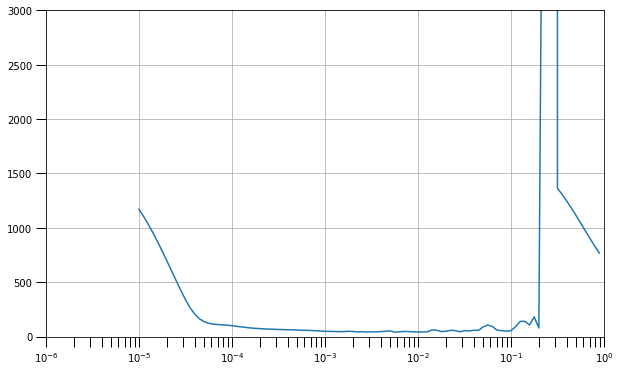

In [56]:
lrs = model.history.history['lr']
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, model.history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-6, 1, 0, 3000])

# Final model

In [71]:
model = tf.keras.Sequential(layers=[
                                    tf.keras.layers.Input(shape=(window_size,)),
                                    tf.keras.layers.Dense(units=32, activation='relu'),
                                    tf.keras.layers.Dense(units=16, activation='relu'),
                                    tf.keras.layers.Dense(units=1)
])
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss="mse", metrics="mae")
model.fit(dataset, epochs=100)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 32)                672       
                                                                 
 dense_37 (Dense)            (None, 16)                528       
                                                                 
 dense_38 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
34/34 [==============================] - 1s 3ms/step - loss: 537.1313 - mae: 15.1981
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 66.5974 - mae: 5.8999
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 62.1470 - mae: 5.7970
Epoch 4/100
34/34 [=========

In [72]:
x_val_predicted= model.predict(val_dataset)
x_val_predicted = x_val_predicted.squeeze()
mse = tf.keras.metrics.mean_squared_error(x_valid, x_val_predicted)
mae = tf.keras.metrics.mean_absolute_error(x_valid, x_val_predicted)
print(f"validation mse :{mse}, mae:{mae}")

validation mse :39.33308029174805, mae:4.661410808563232


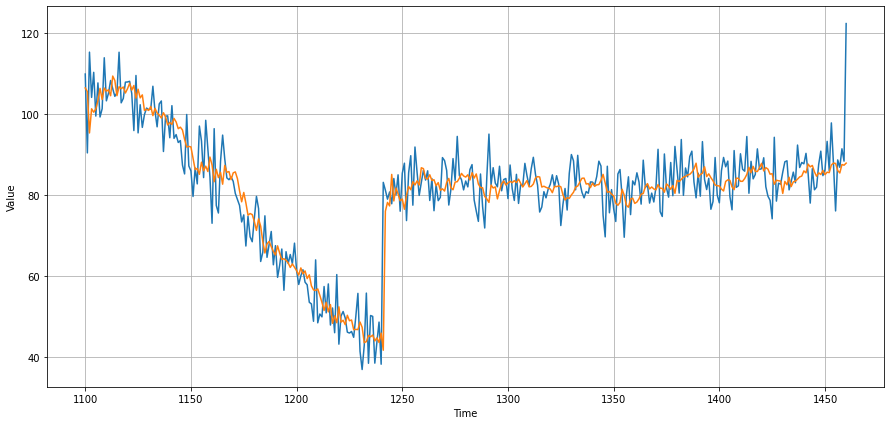

In [73]:
plot_series(time_valid, (x_valid, x_val_predicted))